# MNIST: convolution network



In [1]:
import numpy
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data.dataloader as dataloader
import torch.optim as optim

from torch.utils.data import TensorDataset
from torch.autograd import Variable
from torchvision import transforms
from torchvision.datasets import MNIST,ImageFolder
import matplotlib.pyplot as plt

SEED = 1

# CUDA?
cuda = torch.cuda.is_available()

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

In [2]:

# normalize will center around -1 1
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

train = ImageFolder('/home/ebouletg/3IMA/DL_master/Jupyther_notebook/PPC2/Train', transform=trans )

test = ImageFolder('/home/ebouletg/3IMA/DL_master/Jupyther_notebook/PPC2/Test', transform=trans )


print (train)
# Create DataLoader
dataloader_args = dict(shuffle=True, batch_size=32,num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=32)
train_loader = dataloader.DataLoader(train, **dataloader_args)
test_loader = dataloader.DataLoader(test, **dataloader_args)

#train_data = train.transform(train.train_data.numpy())



Dataset ImageFolder
    Number of datapoints: 179
    Root Location: /home/ebouletg/3IMA/DL_master/Jupyther_notebook/PPC2/Train
    Transforms (if any): Compose(
                             ToTensor()
                             Normalize(mean=(0.1307,), std=(0.3081,))
                         )
    Target Transforms (if any): None


In [10]:
# One hidden Layer NN
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 3, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(3 * 64, 1000)
        self.fc2 = nn.Linear(1000, 10)
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        #out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return F.log_softmax(out, dim=0)    
    
    
model = Model()
if cuda:
    model.cuda()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [11]:
EPOCHS = 200
losses = []

# Eval
dataiterator = iter(test_loader)
evaluate_x, evaluate_y = dataiterator.next()
#evaluate_x = Variable(test_loader.dataset.target_transform)
#evaluate_y = Variable(test_loader.dataset.test_labels)
#evaluate_x = evaluate_x.unsqueeze_(1)
#print(evaluate_x)
if cuda:
    evaluate_x, evaluate_y = evaluate_x.cuda(), evaluate_y.cuda()
train_size = len(train_loader.dataset)
batch_size = (train_size / 32) if (cuda) else  (train_size / 32)

model.train()
for epoch in range(EPOCHS):
    for batch_idx, (data, target) in enumerate(train_loader):
        # Get Samples
        data, target = Variable(data), Variable(target)
        
        if cuda:
            data, target = data.cuda(), target.cuda()
        
        # Init
        optimizer.zero_grad()

        # Predict
        y_pred = model(data) 

         
        # Calculate loss
        loss = F.cross_entropy(y_pred, target)
        losses.append(loss.cpu().item())
        # Backpropagation
        loss.backward()
        optimizer.step()
        
        
        # Display
        if batch_idx % 100 == 1:
            print('\r Train Epoch: {}/{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch+1,
                EPOCHS,
                batch_idx * len(data), 
                train_size,
                100. * batch_idx / batch_size, 
                loss.cpu().item()), 
                end='')
            
    # display final evaluation for this epoch
    model.eval()
    output = model(evaluate_x)
    pred = output.data.max(1)[1]
    d = pred.eq(evaluate_y.data).cpu()
    accuracy = d.sum().item()/d.size()[0]
    
    print('\r Train Epoch: {}/{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\t Test Accuracy: {:.4f}%'.format(
        epoch+1,
        EPOCHS,
        train_size, 
        train_size,
        100. * batch_idx / batch_size, 
        loss.cpu().item(),
        accuracy*100,
        end=''))

 Train Epoch: 1/200 [179/179 (89%)]	Loss: 2.304036	 Test Accuracy: 30.4348%
 Train Epoch: 2/200 [179/179 (89%)]	Loss: 2.334137	 Test Accuracy: 34.7826%
 Train Epoch: 3/200 [179/179 (89%)]	Loss: 2.046067	 Test Accuracy: 30.4348%
 Train Epoch: 4/200 [179/179 (89%)]	Loss: 1.269076	 Test Accuracy: 39.1304%
 Train Epoch: 5/200 [179/179 (89%)]	Loss: 1.065090	 Test Accuracy: 30.4348%
 Train Epoch: 6/200 [179/179 (89%)]	Loss: 0.957176	 Test Accuracy: 52.1739%
 Train Epoch: 7/200 [179/179 (89%)]	Loss: 1.210705	 Test Accuracy: 47.8261%
 Train Epoch: 8/200 [179/179 (89%)]	Loss: 1.252554	 Test Accuracy: 43.4783%
 Train Epoch: 9/200 [179/179 (89%)]	Loss: 1.051289	 Test Accuracy: 47.8261%
 Train Epoch: 10/200 [179/179 (89%)]	Loss: 1.063778	 Test Accuracy: 43.4783%
 Train Epoch: 11/200 [179/179 (89%)]	Loss: 1.229862	 Test Accuracy: 47.8261%
 Train Epoch: 12/200 [179/179 (89%)]	Loss: 1.214651	 Test Accuracy: 43.4783%
 Train Epoch: 13/200 [179/179 (89%)]	Loss: 1.026463	 Test Accuracy: 47.8261%
 Train E

 Train Epoch: 107/200 [179/179 (89%)]	Loss: 0.341360	 Test Accuracy: 43.4783%
 Train Epoch: 108/200 [179/179 (89%)]	Loss: 0.142105	 Test Accuracy: 43.4783%
 Train Epoch: 109/200 [179/179 (89%)]	Loss: 0.137595	 Test Accuracy: 47.8261%
 Train Epoch: 110/200 [179/179 (89%)]	Loss: 0.153420	 Test Accuracy: 47.8261%
 Train Epoch: 111/200 [179/179 (89%)]	Loss: 0.319717	 Test Accuracy: 52.1739%
 Train Epoch: 112/200 [179/179 (89%)]	Loss: 0.565148	 Test Accuracy: 52.1739%
 Train Epoch: 113/200 [179/179 (89%)]	Loss: 0.345553	 Test Accuracy: 52.1739%
 Train Epoch: 114/200 [179/179 (89%)]	Loss: 0.133938	 Test Accuracy: 52.1739%
 Train Epoch: 115/200 [179/179 (89%)]	Loss: 0.135027	 Test Accuracy: 43.4783%
 Train Epoch: 116/200 [179/179 (89%)]	Loss: 0.125906	 Test Accuracy: 47.8261%
 Train Epoch: 117/200 [179/179 (89%)]	Loss: 0.112127	 Test Accuracy: 43.4783%
 Train Epoch: 118/200 [179/179 (89%)]	Loss: 0.123932	 Test Accuracy: 43.4783%
 Train Epoch: 119/200 [179/179 (89%)]	Loss: 0.203503	 Test Accur

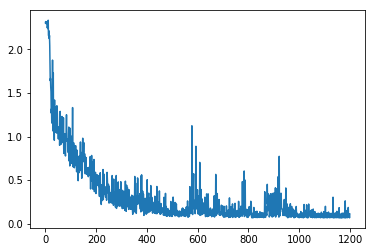

In [12]:
plt.plot(losses)

In [13]:
model.eval()
output = model(evaluate_x)
pred = output.data.max(1)[1]
d = pred.eq(evaluate_y.data).cpu()
accuracy = d.sum().item()/d.size()[0]
print('Accuracy:', accuracy*100)

Accuracy: 43.47826086956522


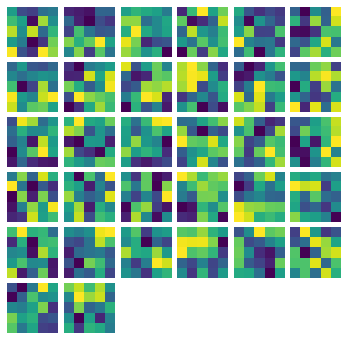

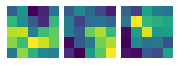

In [14]:
def plot_kernels(tensor, num_cols=6):
    if not tensor.ndim==4:
        raise Exception("assumes a 4D tensor")
    num_kernels = tensor.shape[0]
    num_rows = 1+ num_kernels // num_cols
    fig = plt.figure(figsize=(num_cols,num_rows))
    for i in range(tensor.shape[0]):
        ax1 = fig.add_subplot(num_rows,num_cols,i+1)
        ax1.imshow(tensor[i][0])
        ax1.axis('off')
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])

    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

for m in model.modules():
    if isinstance(m, nn.Conv2d):
        plot_kernels(m.weight.data.numpy())